# <h1 align="center">Trabajo Practico 1: UdeSA Panoramica</h1>

In [1]:
import matplotlib.pyplot as plt
import cv2
from utils import imshow, show_images
import numpy as np

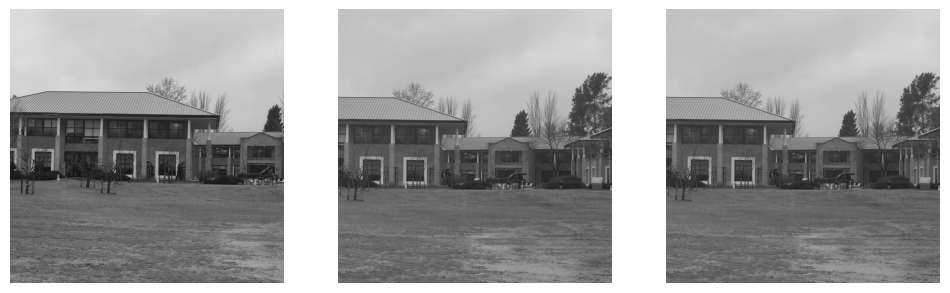

In [2]:
images = [cv2.cvtColor(plt.imread(f'img/udesa_{i}.jpg'), cv2.COLOR_RGB2GRAY) for i in range(0,3)]
show_images(images)

## Deteccion y Descripcion de Caracteristicas Visuales

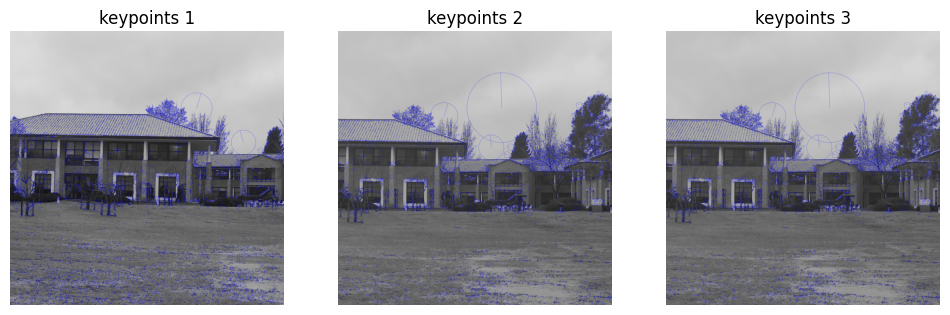

In [3]:
sift_algo = cv2.SIFT_create()
images_keypoints = []
images_descriptors = []

for i in range(len(images)):
    kp, des = sift_algo.detectAndCompute(images[i], None)
    images_keypoints.append(kp)
    images_descriptors.append(des)

images_with_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_kp = cv2.drawKeypoints(
        img_bgr,
        images_keypoints[i],
        0, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_kp.append(img_with_kp)

show_images(images_with_kp, ["keypoints 1", "keypoints 2", "keypoints 3"])

8864 6144 6144


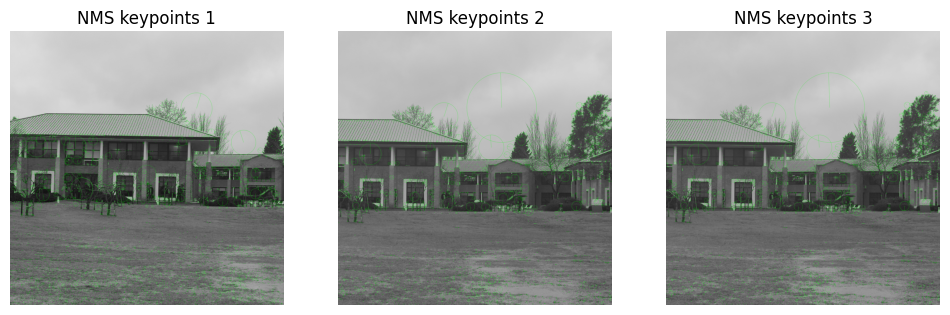

In [4]:
def apply_nms_to_keypoints_with_indices(keypoints, threshold=1000, N=10000):
    if not keypoints:
        return []

    keypoints = sorted(enumerate(keypoints), key=lambda x: x[1].response, reverse=True)
    filtered_indices = []
    filtered_keypoints = []

    for idx, kp in keypoints:
        keep = True
        for filtered_kp in filtered_keypoints:
            dist = np.sqrt((kp.pt[0] - filtered_kp.pt[0])**2 + (kp.pt[1] - filtered_kp.pt[1])**2)
            if dist < threshold:
                keep = False
                break
        if keep:
            filtered_keypoints.append(kp)
            filtered_indices.append(idx)

    return sorted(filtered_indices)[:N] 

nms_indices = []
for kp_list in images_keypoints:
    nms_indices.append(apply_nms_to_keypoints_with_indices(kp_list, threshold=10))

filtered_descriptors = []
for i, indices in enumerate(nms_indices):
    filtered_descriptors.append(images_descriptors[i][indices])

images_with_nms_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_nms_kp = cv2.drawKeypoints(
        img_bgr,
        [images_keypoints[i][idx] for idx in nms_indices[i]],
        0, (0, 255, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_nms_kp.append(img_with_nms_kp)

show_images(images_with_nms_kp, ["NMS keypoints 1", "NMS keypoints 2", "NMS keypoints 3"])
print(len(nms_indices[0]), len(nms_indices[1]), len(nms_indices[2]))

images_descriptors = filtered_descriptors

## Asociacion de Caracteristicas

### Cross-check

Cross matches 0-1: 1280


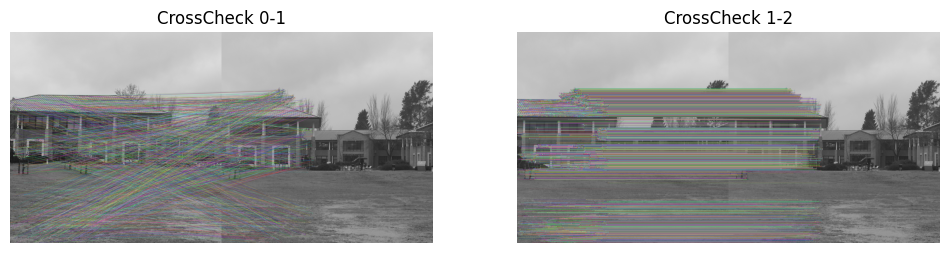

In [5]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def flann_cross_check(desc1, desc2, matcher):
    # Asegurar tipo float32
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)

    matches_1to2 = matcher.match(desc1, desc2)
    matches_2to1 = matcher.match(desc2, desc1)

    # Crear diccionario para reverse lookup: (desc2_index) -> desc1_index
    reverse_matches = {m.trainIdx: m.queryIdx for m in matches_2to1}

    # Filtrar matches que sean mutuos
    mutual_matches = []
    for m in matches_1to2:
        reverse = reverse_matches.get(m.queryIdx)
        if reverse is not None and reverse == m.trainIdx:
            mutual_matches.append(m)

    return sorted(mutual_matches, key=lambda x: x.distance)


# Entre imagen 0 y 1
matches01_cross = flann_cross_check(images_descriptors[0], images_descriptors[1], flann)
print("Cross matches 0-1:", len(matches01_cross))

matched_img01_cross = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Match entre imagen 1 y 2
matches12_cross = flann_cross_check(images_descriptors[1], images_descriptors[2], flann)
matched_img12_cross = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

show_images([matched_img01_cross, matched_img12_cross], ["CrossCheck 0-1", "CrossCheck 1-2"])


In [6]:
print("Cross matches 0-1:", len(matches01_cross))
print("Cross matches 1-2:", len(matches12_cross))

Cross matches 0-1: 1280
Cross matches 1-2: 6144


 ### Lowe´s Ratio

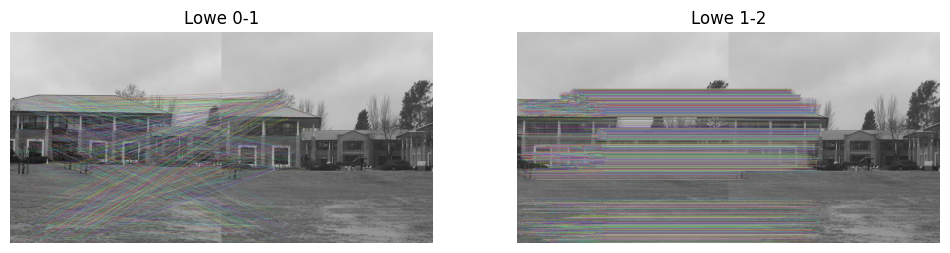

In [7]:
def flann_lowe_test(desc1, desc2, ratio=0.75):
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)
    knn_matches = flann.knnMatch(desc1, desc2, k=2)
    good_matches = [m for m, n in knn_matches if m.distance < ratio * n.distance]
    return good_matches

# Match entre imagen 0 y 1
matches01_lowe = flann_lowe_test(images_descriptors[0], images_descriptors[1])
matched_img01_lowe = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Match entre imagen 1 y 2
matches12_lowe = flann_lowe_test(images_descriptors[1], images_descriptors[2])
matched_img12_lowe = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

show_images([matched_img01_lowe, matched_img12_lowe], ["Lowe 0-1", "Lowe 1-2"])


### Cross-check vs Lowe´s Ratio

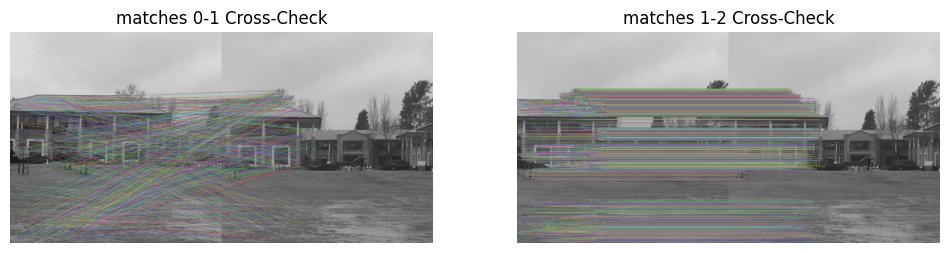

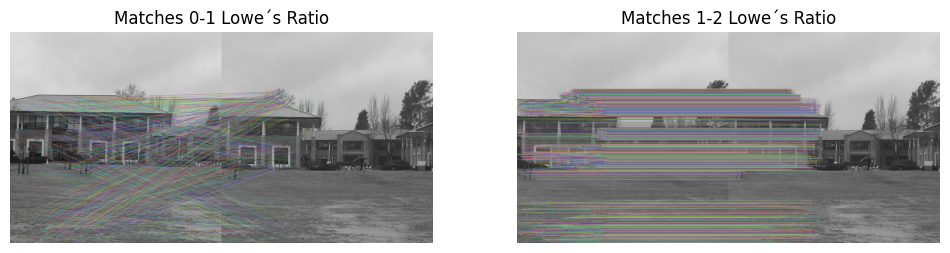

In [8]:
show_images([matched_img01_cross, matched_img12_cross], ["matches 0-1 Cross-Check", "matches 1-2 Cross-Check"])
show_images([matched_img01_lowe, matched_img12_lowe], ["Matches 0-1 Lowe´s Ratio", "Matches 1-2 Lowe´s Ratio"])

In [9]:
def compute_homography_dlt(p1, p2):
    p1 = np.asarray(p1, dtype=float)
    p2 = np.asarray(p2, dtype=float)
    N = p1.shape[0]
    A = []
    for i in range(N):
        x, y = p1[i, 0], p1[i, 1]
        xp, yp = p2[i, 0], p2[i, 1]
        row1 = [0, 0, 0, -x, -y, -1, yp*x, yp*y, yp]
        row2 = [x, y, 1, 0, 0, 0, -xp*x, -xp*y, -xp]
        A.append(row1)
        A.append(row2)
    A = np.asarray(A, dtype=float)
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape((3, 3))
    if H[2, 2] != 0:
        H = H / H[2, 2]
    return H

def apply_homography(H, points):
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed_points = points_homogeneous @ H.T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

def compute_precision(original_points, transformed_points):
    errors = np.linalg.norm(original_points - transformed_points, axis=1)
    return np.mean(errors)

p0 = [
    [2304, 1157],
    [2756, 1360],
    [2930, 1038],
    [2597, 1685],
]

p1 = [
    [1407, 1219],
    [1873, 1407],
    [2025, 1096],
    [1721, 1732],
    [2022, 1548]
]

p2 = [
    [466, 1381],
    [651, 1067],
    [311, 1714],
    [611, 1522]
]

p0_matched = np.array(p0)
p1_matched = np.array(p1[:-1])
H1 = compute_homography_dlt(p0_matched, p1_matched)

p1_matched_2 = np.array(p1[1:])
p2_matched = np.array(p2)
H2 = compute_homography_dlt(p1_matched_2, p2_matched)

p0_to_p1_transformed = apply_homography(H1, p0_matched)
p1_to_p2_transformed = apply_homography(H2, p1_matched_2)

precision_p0_p1 = compute_precision(p1_matched, p0_to_p1_transformed)
precision_p1_p2 = compute_precision(p2_matched, p1_to_p2_transformed)

precision_p0_p1, precision_p1_p2


(1.4924938099771976e-07, 1.5648489034941862e-08)

## RANSAC

In [10]:
def ransac_homography_from_matches(kp1: list, kp2: list, matches: list, max_iterations: int = 1000, threshold: float = 5.0):
    max_inliers = 0
    best_inliers = []
    best_H = None

    for i in range(max_iterations):
        sample_matches = np.random.choice(matches, 4, replace=False)

        # Get the point correspondences
        points1 = np.array([kp1[m.queryIdx].pt for m in sample_matches], dtype=np.float32)
        points2 = np.array([kp2[m.trainIdx].pt for m in sample_matches], dtype=np.float32)

        # Estimate homography
        H = compute_homography_dlt(points1, points2) 

        inliers = []
        for idx, m in enumerate(matches):
            pt1 = np.array([*kp1[m.queryIdx].pt, 1], dtype=np.float32)
            pt2 = np.array([*kp2[m.trainIdx].pt, 1], dtype=np.float32)

            projected_pt = H @ pt1
            projected_pt /= projected_pt[2]
            distance = np.linalg.norm(projected_pt - pt2)

            if distance < threshold:
                inliers.append(m)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = inliers
            best_H = H

    return best_H, best_inliers

ransac_01_H, ransac_01_inliers = ransac_homography_from_matches(
    images_keypoints[0], images_keypoints[1], matches01_cross, max_iterations=1000, threshold=5.0
)
ransac_12_H, ransac_12_inliers = ransac_homography_from_matches(
    images_keypoints[1], images_keypoints[2], matches12_cross, max_iterations=1000, threshold=5.0
)

print(f"RANSAC 0-1: {len(ransac_01_inliers)} inliers")
print(f"RANSAC 1-2: {len(ransac_12_inliers)} inliers")

RANSAC 0-1: 6 inliers
RANSAC 1-2: 6144 inliers


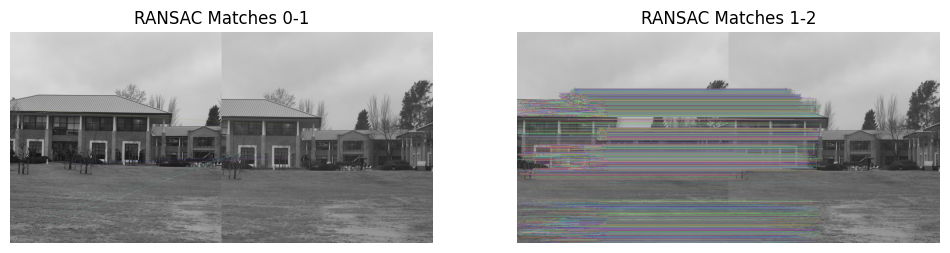

In [11]:
# Draw inliers
inlier_matches_01 = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    ransac_01_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
inlier_matches_12 = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    ransac_12_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
show_images([inlier_matches_01, inlier_matches_12], ["RANSAC Matches 0-1", "RANSAC Matches 1-2"])

In [12]:
# Extraer puntos de los inliers 0-1
pts_01_src = np.float32([images_keypoints[0][m.queryIdx].pt for m in ransac_01_inliers])
pts_01_dst = np.float32([images_keypoints[1][m.trainIdx].pt for m in ransac_01_inliers])

# Homografía usando OpenCV
H_cv2_01, mask_01 = cv2.findHomography(pts_01_src, pts_01_dst, method=cv2.RANSAC, ransacReprojThreshold=5.0)

# Repetir para imágenes 1-2
pts_12_src = np.float32([images_keypoints[1][m.queryIdx].pt for m in ransac_12_inliers])
pts_12_dst = np.float32([images_keypoints[2][m.trainIdx].pt for m in ransac_12_inliers])

H_cv2_12, mask_12 = cv2.findHomography(pts_12_src, pts_12_dst, method=cv2.RANSAC, ransacReprojThreshold=5.0)

print("Homografía 0 → 1 (OpenCV):\n", H_cv2_01)
print("Homografía 1 → 2 (OpenCV):\n", H_cv2_12)


Homografía 0 → 1 (OpenCV):
 [[-3.03965533e-01 -2.99862138e-01  4.15026710e+02]
 [ 2.52809031e+00 -2.60249674e+00  1.56106148e+03]
 [ 1.45012316e-03 -1.54037861e-03  1.00000000e+00]]
Homografía 1 → 2 (OpenCV):
 [[ 1.00000000e+00  6.48672827e-16 -4.04580529e-12]
 [ 1.15019820e-14  1.00000000e+00 -1.10408207e-11]
 [ 6.81698932e-18  5.89230412e-19  1.00000000e+00]]


In [ ]:

def cylindrical_warp(img, f):
    h, w = img.shape[:2]
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))
    xs_c = xs - w / 2
    ys_c = ys - h / 2
    theta = np.arctan(xs_c / f)
    h_ = ys_c / np.sqrt(xs_c**2 + f**2)
    map_x = (f * theta + w / 2).astype(np.float32)
    map_y = (f * h_ + h / 2).astype(np.float32)
    cyl = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return cyl


H0 = H_cv2_01
H1 = np.eye(3)
H2 = np.linalg.inv(H_cv2_12)
H_matrices = [H0, H1, H2]

focal_length = 500 # hay que buscar esto
images = [cv2.cvtColor(plt.imread(f'img/udesa_{i}.jpg'), cv2.COLOR_RGB2GRAY) for i in range(3)] # esto lo redefini porq estaba bug
show_images(images,['img0','img1','img2']) # decime si te muestra las imagenes bien
images_cyl = images
# images_cyl = [cylindrical_warp(img, focal_length) for img in images] # esto lo comente por ahora, despues vemos

def compute_panorama_bounds(images, H_matrices):
    all_corners = []
    for img, H in zip(images, H_matrices):
        h, w = img.shape[:2]
        corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners, H)
        all_corners.append(warped_corners)
    all_corners = np.vstack(all_corners)
    x_min = int(np.floor(all_corners[:, 0, 0].min()))
    y_min = int(np.floor(all_corners[:, 0, 1].min()))
    x_max = int(np.ceil(all_corners[:, 0, 0].max()))
    y_max = int(np.ceil(all_corners[:, 0, 1].max()))
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = compute_panorama_bounds(images_cyl, H_matrices)
print("limites", x_min, y_min, x_max, y_max)

translation = np.array([[1, 0, -x_min],
                        [0, 1, -y_min],
                        [0, 0, 1]])
pano_width = x_max - x_min
pano_height = y_max - y_min

warped_images = []
for idx, (img, H) in enumerate(zip(images_cyl, H_matrices)):
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    warped = cv2.warpPerspective(img, translation @ H, (pano_width, pano_height))
    warped_images.append(warped)
    imshow(warped)

panorama = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)
for warped in warped_images:
    mask = (warped > 0)
    panorama[mask] = warped[mask]

imshow(panorama)


NameError: name 'H0' is not defined